# Reinforcement Learning Part 2: Deep Q-Learning on CartPole

This notebook will explore deep reinforcement learning on the CartPole-v1 environment.

## 1. Setup

In [28]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from typing import List, Dict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
print(f"Environment: CartPole-v1 | State dim: {state_dim} | Action dim: {action_dim}")

Environment: CartPole-v1 | State dim: 4 | Action dim: 2


## 2. DQN Model

In [ ]:
# figure 45
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, output_dim)
        )

    def forward(self, x):
        return self.model(x)


## 3. Experience Replay Buffer 

In [30]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (
            torch.tensor(states, dtype=torch.float32, device=device),
            torch.tensor(actions, dtype=torch.int64, device=device),
            torch.tensor(rewards, dtype=torch.float32, device=device),
            torch.tensor(next_states, dtype=torch.float32, device=device),
            torch.tensor(dones, dtype=torch.float32, device=device)
        )

    def __len__(self):
        return len(self.buffer)

## 4. Exploration Strategies

In [31]:
def epsilon_greedy(q_values, epsilon):
    if random.random() < epsilon:
        return random.randint(0, len(q_values) - 1)
    return torch.argmax(q_values).item()

def boltzmann_policy(q_values, temperature):
    q_vals = q_values.detach().cpu().numpy()
    
    q_vals = q_vals - np.max(q_vals)  
    exp_q = np.exp(q_vals / temperature)
    probs = exp_q / np.sum(exp_q)

    return np.random.choice(len(q_vals), p=probs)


## 5. DQN Training Function

In [32]:
def train_dqn(exploration="epsilon", hyperparams=None, max_episodes=500, max_steps=200, target_score=475, verbose=False):
    policy_net = DQN(state_dim, action_dim).to(device)
    target_net = DQN(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=hyperparams["lr"])
    replay_buffer = ReplayBuffer(capacity=hyperparams["buffer_size"])

    epsilon = hyperparams.get("epsilon_start", 1.0)
    target_update_freq = hyperparams.get("target_update_freq", 10)
    rewards_history, losses, avg_q_values = [], [], []

    for ep in range(max_episodes):
        state, _ = env.reset()
        total_reward = 0
        episode_qs = []

        for _ in range(max_steps):
            state_tensor = torch.tensor([state], dtype=torch.float32, device=device)
            q_values = policy_net(state_tensor)[0]
            episode_qs.append(q_values.mean().item())

            if exploration == "epsilon":
                action = epsilon_greedy(q_values, epsilon)
            elif exploration == "boltzmann":
                action = boltzmann_policy(q_values, hyperparams["temperature"])
            else:
                raise ValueError("Invalid exploration method")

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            replay_buffer.add(state, action, reward, next_state, done)

            state = next_state
            total_reward += reward

            if len(replay_buffer) >= hyperparams["train_start"]:
                s, a, r, s_next, d = replay_buffer.sample(hyperparams["batch_size"])

                with torch.no_grad():
                    q_next = target_net(s_next).max(1)[0]
                    targets = r + hyperparams["gamma"] * q_next * (1 - d)

                q_pred = policy_net(s).gather(1, a.unsqueeze(1)).squeeze()
                loss = nn.functional.mse_loss(q_pred, targets)

                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
                optimizer.step()
                losses.append(loss.item())

            if done:
                break

        rewards_history.append(total_reward)
        avg_q_values.append(np.mean(episode_qs))

        if exploration == "epsilon":
            epsilon = max(hyperparams["epsilon_min"], epsilon * hyperparams["epsilon_decay"])

        if (ep + 1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if verbose and (ep + 1) % 50 == 0:
            avg = np.mean(rewards_history[-50:])
            print(f"Episode {ep+1}, Avg Reward: {avg:.2f}, Epsilon: {epsilon:.3f}")

        if np.mean(rewards_history[-50:]) >= target_score:
            if verbose:
                print(f"Solved in {ep+1} episodes!")
            break

    return rewards_history, losses, avg_q_values, policy_net


## 6.Visualization Utilities

In [33]:
def plot_rewards(rewards, window=50, label=None):
    smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, label=label or "Average Reward")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)

def plot_losses(losses, window=50, label=None):
    smoothed = np.convolve(losses, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, label=label or "Loss")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.legend()
    plt.grid(True)

def compare_rewards(config_results: Dict[str, List[float]], window=50):
    plt.figure(figsize=(10, 6))
    for label, rewards in config_results.items():
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(smoothed, label=label)
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.title("Reward Comparison Across Configurations")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_q_values(q_values, window=50, label=None):
    smoothed = np.convolve(q_values, np.ones(window)/window, mode='valid')
    plt.plot(smoothed, label=label or "Avg Q-value")
    plt.xlabel("Episode")
    plt.ylabel("Average Q-value")
    plt.title("Average Q-values Per Episode")
    plt.legend()
    plt.grid(True)

## 7. Hyperparameters Search

In [34]:
def run_hyperparam_search(strategy, configs, env_name="CartPole-v1", episodes=300):
    results = []
    reward_logs = {}

    for i, cfg in enumerate(configs):
        label = f"Config {i + 1}"
        print(f"\n▶️ Running {label} with {strategy}...")
        
        rewards, _, _, _ = train_dqn(
            exploration=strategy,
            hyperparams={
                "lr": cfg["learning_rate"],
                "gamma": cfg["gamma"],
                "epsilon_start": cfg.get("epsilon_start", 1.0),
                "epsilon_min": cfg.get("epsilon_min", 0.1),
                "epsilon_decay": cfg.get("epsilon_decay", 0.995),
                "temperature": cfg.get("tau", 1.0),
                "batch_size": cfg["batch_size"],
                "buffer_size": 10000,
                "train_start": 1000,
                "train_freq": 1
            },
            max_episodes=episodes
        )

        avg_reward = np.mean(rewards[-50:])
        results.append((avg_reward, cfg))
        reward_logs[label] = rewards

    best = max(results, key=lambda x: x[0])
    print(f"\n✅ Best config for {strategy}: {best[1]} with avg reward {best[0]:.2f}")
    
    return best[1], reward_logs


## 8. Agent Evaluation

In [35]:
def evaluate_agent(model, env_name='CartPole-v1', episodes=5):
    env = gym.make(env_name, render_mode='human')
    model.eval()
    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            state_tensor = torch.tensor([state], dtype=torch.float32, device=device)
            with torch.no_grad():
                action = torch.argmax(model(state_tensor)).item()
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward
            done = terminated or truncated
        print(f"Episode {ep + 1}: Total Reward = {total_reward}")
    env.close()

## 9. Run DQN with Epsilon-Greedy

In [ ]:
# figure 46
configs_eps = [
    # config 1
    {'learning_rate': 0.01, 'batch_size': 32, 'epsilon_start': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.995, 'gamma': 0.99, 'tau': 1.0},
    # config 2
    {'learning_rate': 0.001, 'batch_size': 64, 'epsilon_start': 1.0, 'epsilon_min': 0.1, 'epsilon_decay': 0.99, 'gamma': 0.98, 'tau': 1.0},
    # config 3
    {'learning_rate': 0.005, 'batch_size': 16, 'epsilon_start': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.98, 'gamma': 0.99, 'tau': 1.0},
    # config 4
    {'learning_rate': 0.002, 'batch_size': 64, 'epsilon_start': 1.0, 'epsilon_min': 0.1, 'epsilon_decay': 0.97, 'gamma': 0.97, 'tau': 1.0},
    # config 5
    {'learning_rate': 0.0005, 'batch_size': 32, 'epsilon_start': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.99, 'gamma': 0.95, 'tau': 1.0},
    # config 6
    {'learning_rate': 0.005, 'batch_size': 48, 'epsilon_start': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.98, 'gamma': 0.985, 'tau': 1.0}
]

In [37]:
best_eps_config, reward_logs_eps = run_hyperparam_search("epsilon", configs_eps)


▶️ Running Config 1 with epsilon...

▶️ Running Config 2 with epsilon...

▶️ Running Config 3 with epsilon...

▶️ Running Config 4 with epsilon...

▶️ Running Config 5 with epsilon...

▶️ Running Config 6 with epsilon...

✅ Best config for epsilon: {'learning_rate': 0.0005, 'batch_size': 32, 'epsilon_start': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.99, 'gamma': 0.95, 'tau': 1.0} with avg reward 178.82


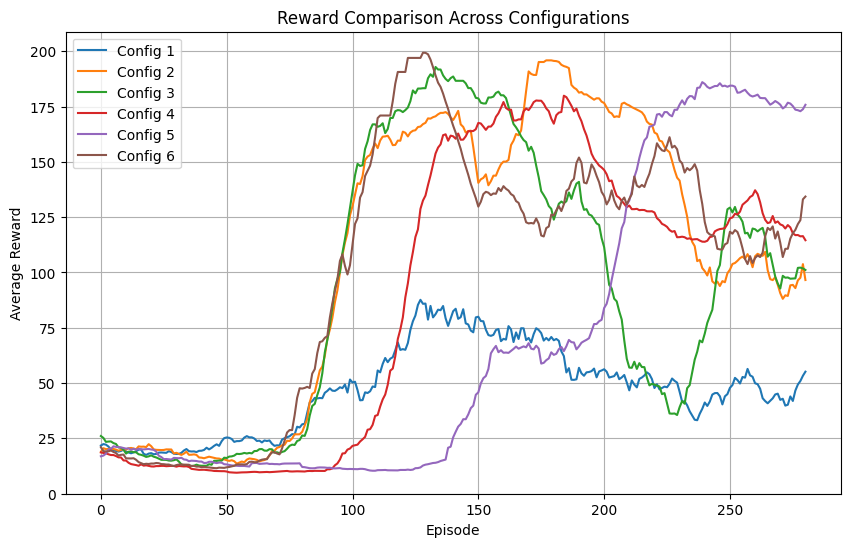

In [ ]:
# figure 47
compare_rewards(reward_logs_eps, window=20)

In [39]:
rewards_eps, losses_eps, qvals_eps, model_eps = train_dqn(
    exploration="epsilon",
    hyperparams={
        "lr": best_eps_config["learning_rate"],
        "gamma": best_eps_config["gamma"],
        "epsilon_start": best_eps_config["epsilon_start"],
        "epsilon_min": best_eps_config["epsilon_min"],
        "epsilon_decay": best_eps_config["epsilon_decay"],
        "batch_size": best_eps_config["batch_size"],
        "buffer_size": 10000,
        "train_start": 1000,
        "train_freq": 1,
        "temperature": 1.0
    },
    max_episodes=1000
)

## 10. Run DQN with Boltzmann

In [ ]:
# figure 48
configs_boltz = [
    # config 1
    {'learning_rate': 0.01, 'batch_size': 32, 'epsilon_start': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.995, 'gamma': 0.99, 'tau': 1.0},
    # config 2
    {'learning_rate': 0.005, 'batch_size': 64, 'epsilon_start': 1.0, 'epsilon_min': 0.1, 'epsilon_decay': 0.99, 'gamma': 0.98, 'tau': 0.5},
    # config 3
    {'learning_rate': 0.001, 'batch_size': 16, 'epsilon_start': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.98, 'gamma': 0.99, 'tau': 0.7},
    # config 4
    {'learning_rate': 0.002, 'batch_size': 64, 'epsilon_start': 1.0, 'epsilon_min': 0.1, 'epsilon_decay': 0.97, 'gamma': 0.97, 'tau': 0.8},
    # config 5
    {'learning_rate': 0.0005, 'batch_size': 32, 'epsilon_start': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.99, 'gamma': 0.95, 'tau': 0.6},
    # config 6
    {'learning_rate': 0.005, 'batch_size': 48, 'epsilon_start': 1.0, 'epsilon_min': 0.05, 'epsilon_decay': 0.98, 'gamma': 0.985, 'tau': 0.9}
]

In [41]:
best_boltz_config, reward_logs_boltz = run_hyperparam_search("boltzmann", configs_boltz)


▶️ Running Config 1 with boltzmann...

▶️ Running Config 2 with boltzmann...

▶️ Running Config 3 with boltzmann...

▶️ Running Config 4 with boltzmann...

▶️ Running Config 5 with boltzmann...

▶️ Running Config 6 with boltzmann...

✅ Best config for boltzmann: {'learning_rate': 0.005, 'batch_size': 64, 'epsilon_start': 1.0, 'epsilon_min': 0.1, 'epsilon_decay': 0.99, 'gamma': 0.98, 'tau': 0.5} with avg reward 127.60


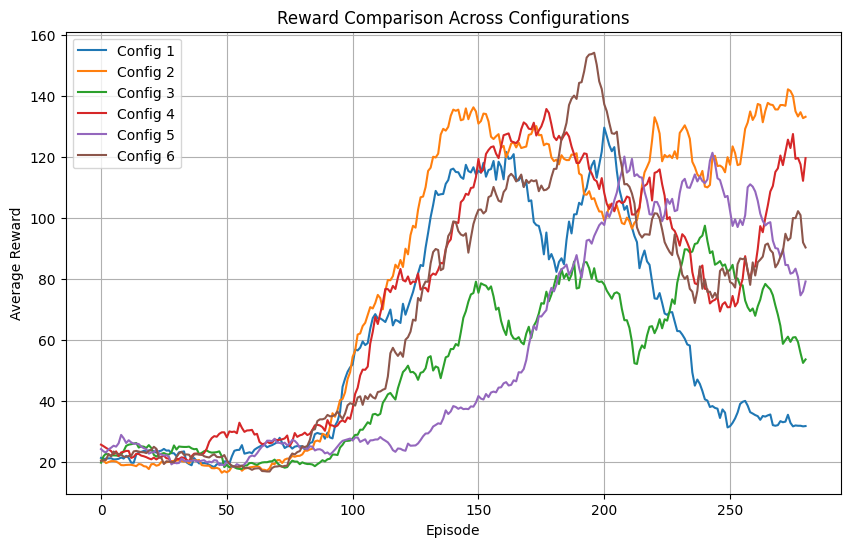

In [ ]:
# figure 49
compare_rewards(reward_logs_boltz, window=20)

In [43]:
rewards_boltz, losses_boltz, qvals_boltz, model_boltz = train_dqn(
    exploration="boltzmann",
    hyperparams={
        "lr": best_boltz_config["learning_rate"],
        "gamma": best_boltz_config["gamma"],
        "temperature": best_boltz_config["tau"],
        "batch_size": best_boltz_config["batch_size"],
        "buffer_size": 10000,
        "train_start": 1000,
        "train_freq": 1
    },
    max_episodes=1000
)

## 11. Plotting

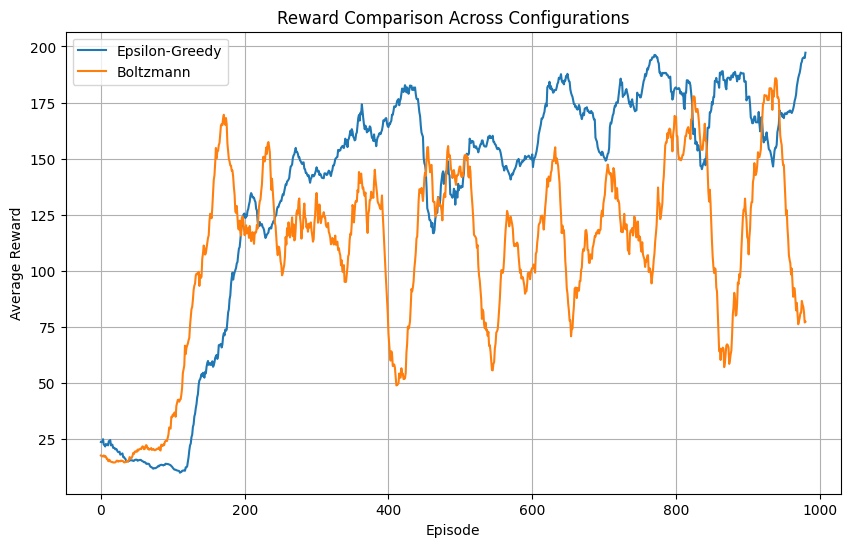

In [ ]:
# figure 50
compare_rewards({
    "Epsilon-Greedy": rewards_eps,
    "Boltzmann": rewards_boltz
}, window=20)

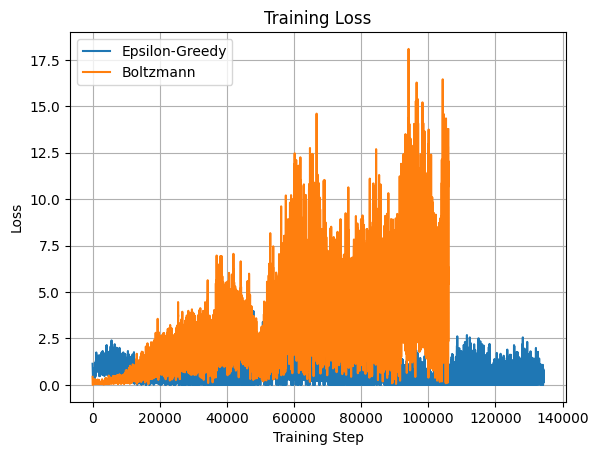

In [ ]:
# figure 51
plot_losses(losses_eps, window=20, label="Epsilon-Greedy")
plot_losses(losses_boltz, window=20, label="Boltzmann")
plt.legend()
plt.show()

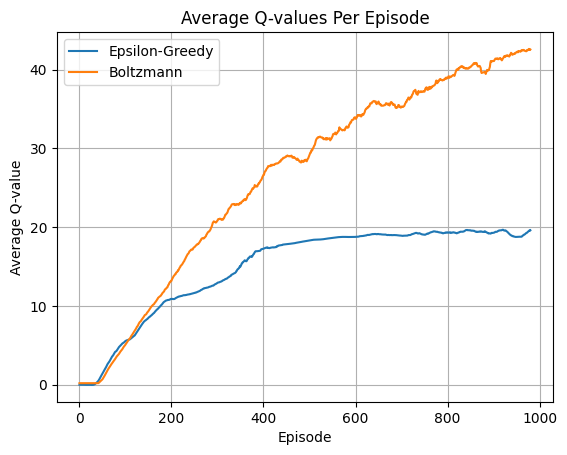

In [ ]:
# figure 52
plot_q_values(qvals_eps, window=20, label="Epsilon-Greedy")
plot_q_values(qvals_boltz, window=20, label="Boltzmann")
plt.legend()
plt.show()

In [ ]:
# figure 53
print("Epsilon-Greedy Agent:")
evaluate_agent(model_eps, env_name='CartPole-v1', episodes=10)

print("\nBoltzmann Agent:")
evaluate_agent(model_boltz, env_name='CartPole-v1', episodes=10)

Epsilon-Greedy Agent:
Episode 1: Total Reward = 218.0
Episode 2: Total Reward = 265.0
Episode 3: Total Reward = 347.0
Episode 4: Total Reward = 279.0
Episode 5: Total Reward = 188.0
Episode 6: Total Reward = 194.0
Episode 7: Total Reward = 216.0
Episode 8: Total Reward = 161.0
Episode 9: Total Reward = 311.0
Episode 10: Total Reward = 300.0

Boltzmann Agent:
Episode 1: Total Reward = 500.0
Episode 2: Total Reward = 500.0
Episode 3: Total Reward = 500.0
Episode 4: Total Reward = 500.0
Episode 5: Total Reward = 500.0
Episode 6: Total Reward = 500.0
Episode 7: Total Reward = 500.0
Episode 8: Total Reward = 500.0
Episode 9: Total Reward = 500.0
Episode 10: Total Reward = 500.0
